In [ ]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# image utils
import PIL
from PIL import Image

# import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# import machine learning
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

Load Data

Load the data as pandas dataframes:

In [ ]:
play_df = pd.read_csv('/content/sample_data/PlayList.csv')
# player_df = pd.read_csv('../input/nfl-playing-surface-analytics/PlayerTrackData.csv')
injury_df = pd.read_csv('/content/sample_data/InjuryRecord.csv')

**Data Exploration**
First of all, we would like to perform the initial cleaning and make visualizations to get familiar with the data and generate the ideas for further analysis.

In [ ]:
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop

In [ ]:
def add_value_labels(ax, spacing=5, decimals = 0):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        format_str = "{:." + str(decimals) + "f}"
        label = format_str.format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


def visualize_game_features(game_df, rotation = 90, add_labels = False, figsize=(10,10)):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 3, hspace=0.2, wspace=0.2)
    stadium_ax = fig.add_subplot(grid[0, :2])
    fieldtype_ax = fig.add_subplot(grid[0, 2])
    weather_ax = fig.add_subplot(grid[1, 0:])
    temperature_ax = fig.add_subplot(grid[2, 0:])
    temperature_box_ax = fig.add_subplot(grid[3, 0:])

    stadium_ax.bar(game_df.StadiumType.value_counts().keys(), game_df.StadiumType.value_counts().values, color='#00c2c7')
    stadium_ax.set_title('StadiumType')
    stadium_ax.set_xticklabels(game_df.StadiumType.value_counts().keys(), rotation=rotation)

    if add_labels:
        add_value_labels(stadium_ax, spacing=5)

    fieldtype_ax.bar(game_df.FieldType.value_counts().keys(), game_df.FieldType.value_counts().values, color=['#00c2c7', '#ff9e15'])
    fieldtype_ax.set_title('FieldType')
    fieldtype_ax.set_xticklabels(game_df.FieldType.value_counts().keys(), rotation=0)

    if add_labels:
        add_value_labels(fieldtype_ax, spacing=5)

    weather_ax.bar(game_df.Weather.value_counts().keys(), game_df.Weather.value_counts().values, color='#00c2c7')
    weather_ax.set_title('Weather')
    weather_ax.set_xticklabels(game_df.Weather.value_counts().keys(), rotation=rotation)

    if add_labels:
        add_value_labels(weather_ax, spacing=5)

    temperature_ax.hist(game_df.Temperature.astype(int).values, bins=30, range=(0,90))
    temperature_ax.set_xlim(0,110)
    temperature_ax.set_xticks(range(0,110,10))
    temperature_ax.set_xticklabels(range(0,110,10))
    temperature_ax.set_title('Temperature')

    temperature_box_ax.boxplot(game_df.Temperature.astype(int).values, vert=False)
    temperature_box_ax.set_xlim(0,110)
    temperature_box_ax.set_xticks(range(0,110,10))
    temperature_box_ax.set_xticklabels(range(0,110,10))
    temperature_box_ax.set_yticklabels(['Temperature'])

    plt.suptitle('Game-Level Exploration', fontsize=16)
    plt.show()

In [ ]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']

    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']

    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']

    snow = ['Heavy lake effect snow']

    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']

    if row.Weather in cloudy:
        return 'Cloudy'

    if row.Weather in indoor:
        return 'Indoor'

    if row.Weather in clear:
        return 'Clear'

    if row.Weather in rainy:
        return 'Rain'

    if row.Weather in snow:
        return 'Snow'

    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan

    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def clean_play_df(play_df):
    play_df_cleaned = play_df.copy()

    # clean StadiumType
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace('Open', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)

    # clean Weather
    play_df_cleaned['Weather'] = play_df_cleaned.apply(lambda row: clean_weather(row), axis=1)

    return play_df_cleaned

<ipython-input-11-a7d17a9c9ee9>:56: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
<ipython-input-11-a7d17a9c9ee9>:57: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
<ipython-input-11-a7d17a9c9ee9>:58: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
<ipython-input-11-a7d17a9c9ee9>:59: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df

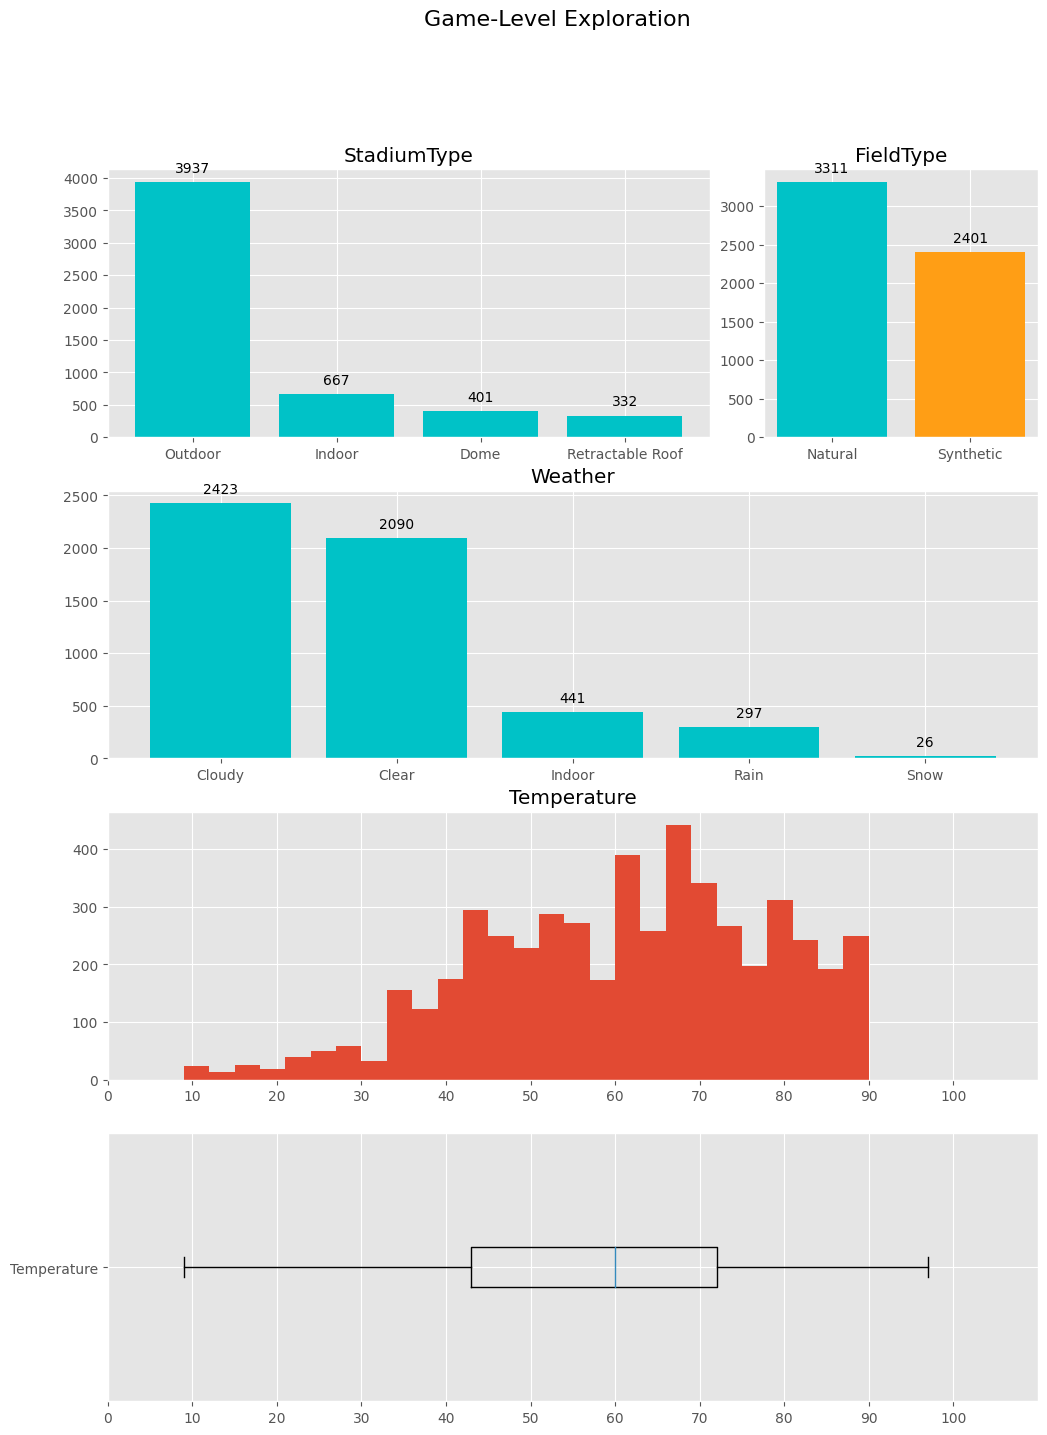

In [ ]:
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])
visualize_game_features(game_df_cleaned, rotation=0, add_labels = True, figsize=(12,16))

In [ ]:
player_data_df = play_df_cleaned[['PlayerKey', 'RosterPosition', 'PlayerGamePlay', 'Position', 'PositionGroup']]

In [ ]:
def visualize_player_features(player_df, figsize=(25,20), add_labels=False):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)

    grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)

    plays_ax = fig.add_subplot(grid[0, 0:2])
    max_rolling_plays_ax = fig.add_subplot(grid[1, 0:2])

    rosterposition_ax = fig.add_subplot(grid[0, 2:])
    positiongroup_ax = fig.add_subplot(grid[1, 2:])
    position_ax = fig.add_subplot(grid[2, 0:])

    plays_ax.hist(player_df.groupby(by=['PlayerKey']).count()['RosterPosition'].values, bins=20, color='#00c2c7')
    plays_ax.set_title('Number of plays per player')

    max_rolling_plays_ax.hist(player_df.groupby(by=['PlayerKey']).PlayerGamePlay.max().values, bins=20, color='#00c2c7')
    max_rolling_plays_ax.set_title('Maximum number of rolling plays per player')

    rosterposition_ax.bar(player_df.RosterPosition.value_counts().keys().values, player_df.RosterPosition.value_counts().values)
    rosterposition_ax.set_xticklabels(player_df.RosterPosition.value_counts().keys().values, rotation=20)
    rosterposition_ax.set_title('Roster Position')
    if add_labels:
        add_value_labels(rosterposition_ax, spacing=5)

    position_ax.bar(player_df.Position.value_counts().keys().values, player_df.Position.value_counts().values, color='#ff9e15')
    position_ax.set_title('Position')
    if add_labels:
        add_value_labels(position_ax, spacing=5)

    positiongroup_ax.bar(player_df.PositionGroup.value_counts().keys().values, player_df.PositionGroup.value_counts().values)
    positiongroup_ax.set_title('Position Group')
    if add_labels:
        add_value_labels(positiongroup_ax, spacing=5)

    plt.suptitle('Player-Level Exploration', fontsize=16)
    plt.show()

In [ ]:
def visualize_play(play_df_cleaned):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    plt.bar(play_df_cleaned.PlayType.value_counts().keys().values, play_df_cleaned.PlayType.value_counts().values)
    plt.xticks(range(len(play_df_cleaned.PlayType.value_counts().keys().values)), play_df_cleaned.PlayType.value_counts().keys().values, rotation=20)
    add_value_labels(ax, spacing=5)
    plt.title('Play-Level Exploration: PlayType', fontsize=16)

    plt.show()

TEXT

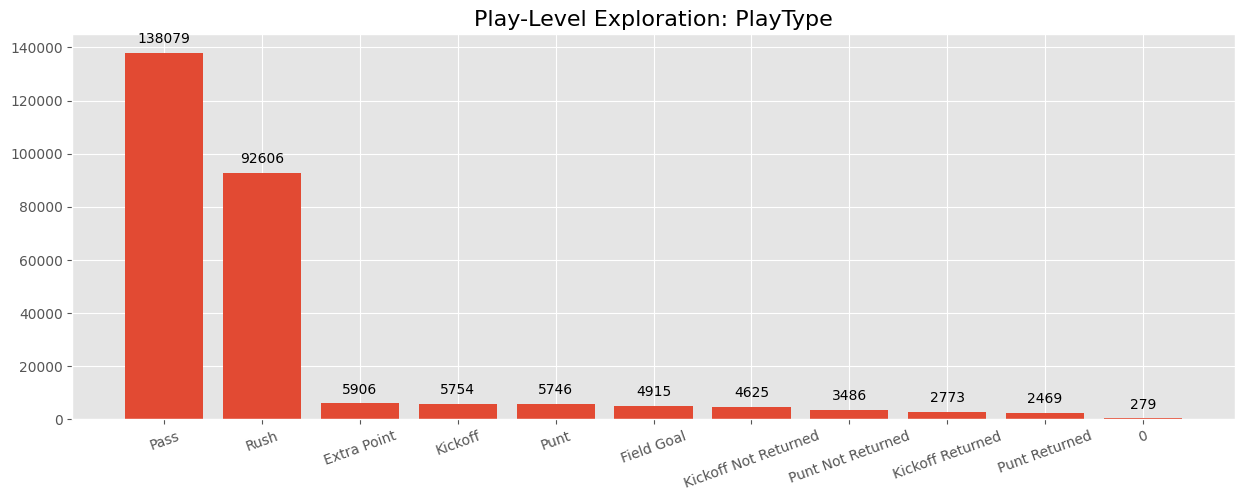

In [ ]:
visualize_play(play_df_cleaned)

In [ ]:
def get_position(player_df, playkey, time):
    '''
    Helper function to get the player position at a certain time
    '''
    row = player_df[(player_df['PlayKey']==playkey) & (player_df['time']==time)]
    event = row['event'].values[0]
    x = row['x'].values[0]
    y = row['y'].values[0]
    direction = row['dir'].values[0]
    distance = row['dis'].values[0]
    orientation = row['o'].values[0]
    speed = row['s'].values[0]

    return event, x, y, direction, distance, orientation, speed

def visualize_player_position(player_df, playkey, time, figsize=(24,10)):
    '''
    Helper function to visualize a single player position.
    '''

    event, x, y, direction, distance, orientation, speed = get_position(player_df, playkey, time)

    background = Image.open('../input/nfl-utils/nfl_coordinates.png')
    background = background.resize((1200,533))
    background = background.transpose(PIL.Image.FLIP_TOP_BOTTOM)

    # show background
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.array(background).transpose(0,1,2), origin='lower')

    # show orientation
    dx = 5
    dy = dx*np.tan(np.radians(90 + orientation))
    plt.arrow(x*10,y*10,dx,dy, color = '#767676', width=5)
    plt.plot(x*10,y*10,color = '#767676', label='orientation')

    # show speed
    dx = speed*20
    dy = dx*np.tan(np.radians(90 + direction))
    plt.arrow(x*10,y*10,dx,dy, color = '#004c97', width=5)
    plt.plot(x*10,y*10, color = '#004c97', label='speed')

    # show current player position
    plt.scatter(x*10,y*10,s=200,color='#e01e5a',marker='x')
    plt.annotate('({x:.1f},{y:.1f})'.format(x=x,y=y), (x*10, y*10), xytext=(x*10,y*10-30), color='#e01e5a')

    plt.xticks(range(0,1200,100), range(0,120,10))
    plt.yticks(range(0,533,100), range(0,53,10))

    plt.title('{play}:{time} {event}'.format(play=playkey, time=time, event = event))

    plt.legend()
    plt.show()

In [ ]:
visualize_player_position(player_df, '26624-1-1', 0.0, figsize=(10,5))

NameError: ignored

TEXT

In [ ]:
visualize_player_position(player_df, '47888-13-55', 35.9, figsize=(10,5))

TEXT

In [ ]:
def visualize_player_track(player_df, playkey, figsize=(24,10), max_positions = 5):
    '''
    Helper function to visualize the whole path of the player
    '''
    # get timestamps per player
    timestamps = player_df[player_df['PlayKey'] == playkey].time.unique()

    background = Image.open('../input/nfl-utils/nfl_coordinates.png')
    background = background.resize((1200,533))
    background = background.transpose(PIL.Image.FLIP_TOP_BOTTOM)

    # show background
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.array(background).transpose(0,1,2), origin='lower')

    # iterate through timestamps
    positions_x, positions_y = [], []
    for i in range(0, len(timestamps), len(timestamps) // max_positions):
        time = timestamps[i]
        # get position and orientation
        event, x, y, direction, distance, orientation, speed = get_position(player_df, playkey, time)
        positions_x.append(x*10)
        positions_y.append(y*10)

        # plot orientation and speed for the lasi point
        if (len(timestamps) - i < len(timestamps) // max_positions):
            # show orientation
            dx = 5
            dy = dx*np.tan(np.radians(90 + orientation))
            plt.arrow(x*10,y*10,dx,dy, color = '#767676', width=5)
            plt.plot(x*10,y*10,color = '#767676', label='orientation')

            # show speed
            dx = speed*20
            dy = dx*np.tan(np.radians(90 + direction))
            plt.arrow(x*10,y*10,dx,dy, color = '#004c97', width=5)
            plt.plot(x*10,y*10, color = '#004c97', label='speed')

            # add x-marker and annotation only for the last position
            plt.scatter(x*10,y*10,s=200,color='#e01e5a',marker='x')
            plt.annotate('({x:.1f},{y:.1f})'.format(x=x,y=y), (x*10, y*10), xytext=(x*10,y*10-30), color='#e01e5a')

    # show player's path
    plt.scatter(positions_x,positions_y,s=50,color='#e01e5a',marker='o')
    plt.plot(positions_x,positions_y,color='#e01e5a', label='player path', linestyle='--')

    # creat custom tick labels
    plt.xticks(range(0,1200,100), range(0,120,10))
    plt.yticks(range(0,533,100), range(0,53,10))

    # add title
    plt.title('{play}'.format(play=playkey))

    plt.legend()
    plt.show()

TEXT

In [ ]:
def visualize_field_heatmap(player_df, xbins=13, ybins=6, annotate = False):
    # create a grid
    x = np.linspace(0, 120, xbins)
    y = np.linspace(0, 53, ybins)

    # initialize heatmap
    hmap = np.zeros((xbins,ybins))

    for i in range(xbins-1):
        for j in range(ybins-1):
            hmap[i,j] = len(player_df[(player_df.x >= x[i]) & (player_df.x <= x[i+1]) & (player_df.y >= y[j]) & (player_df.y <= y[j+1])])

    fig = plt.figure(figsize=(10,5))
    ax = sns.heatmap(np.transpose(hmap), annot=annotate, fmt = '.0f')
    plt.title('Field Heatmap \n the most visited areas of the field are highlighted')
    plt.show()

TEXT

In [ ]:
visualize_field_heatmap(player_df)

In [ ]:
print('There are {} injury records in total.'.format(len(injury_df)))

In [ ]:
print('{} unique players injured'.format(len(injury_df.PlayerKey.unique())))

In [ ]:
print('There are {} PlayKey values missing.'.format(len(injury_df) - injury_df.PlayKey.count()))

In [ ]:
def visualize_injury(injury_df):
    injury_df_cleaned = injury_df.copy()
    injury_df_cleaned.DM_M1 = injury_df_cleaned.DM_M1 - injury_df_cleaned.DM_M7
    injury_df_cleaned.DM_M7 = injury_df_cleaned.DM_M7 - injury_df_cleaned.DM_M28
    injury_df_cleaned.DM_M28 = injury_df_cleaned.DM_M28 - injury_df_cleaned.DM_M42

    fig, axs = plt.subplots(1,3, figsize=(15,5))

    axs[0].bar(injury_df_cleaned.BodyPart.value_counts().keys().values, injury_df_cleaned.BodyPart.value_counts().values, color='#00c2c7')
    axs[0].set_title('Body Part')
    add_value_labels(axs[0], spacing=5)

    axs[1].bar(injury_df_cleaned.Surface.value_counts().keys().values, injury_df_cleaned.Surface.value_counts().values, color='#ff9e15')
    axs[1].set_title('Surface')
    add_value_labels(axs[1], spacing=5)

    M1 = injury_df_cleaned.DM_M1.sum()
    M7 = injury_df_cleaned.DM_M7.sum()
    M28 = injury_df_cleaned.DM_M28.sum()
    M42 = injury_df_cleaned.DM_M42.sum()

    axs[2].bar(['1-7', '7-28', '28-42', '>=42'], [M1, M7, M28, M42])
    axs[2].set_title('Missed Days')
    add_value_labels(axs[2], spacing=5)

    plt.suptitle('Injury', fontsize=16)
    plt.show()

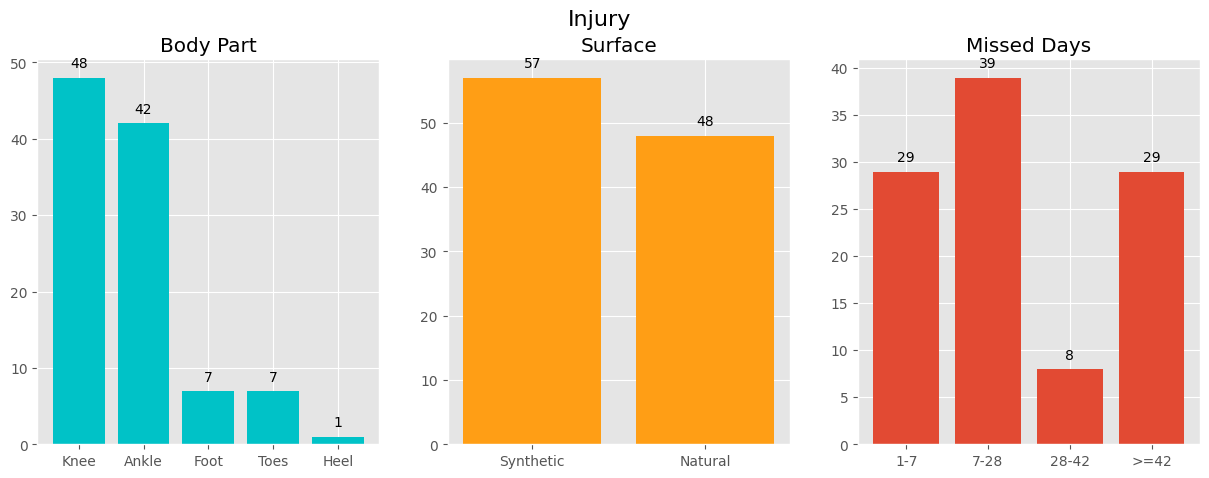

In [ ]:
visualize_injury(injury_df)

In [ ]:
# joined cleaned games dataset and injury dataset
game_injury_df = injury_df.set_index('GameID').join(game_df_cleaned.set_index('GameID'), how = 'outer')

# fill null values for the injury columns with zeros
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)

game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42

# introduce a column with a flag indicating an injury
game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7'] + game_injury_df['DM_M28'] + game_injury_df['DM_M42']

# drop duplicated surface column
game_injury_df = game_injury_df.drop(columns=['Surface'])

# drop play-level features just for now
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey'])

# create dummy variables
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

TEXT

In [ ]:
# Source:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [ ]:
# Source:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def plot_cramers_v_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(pd.crosstab(df[col1], df[col2]).values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); ax.set_title("Cramer V Correlation between Variables");


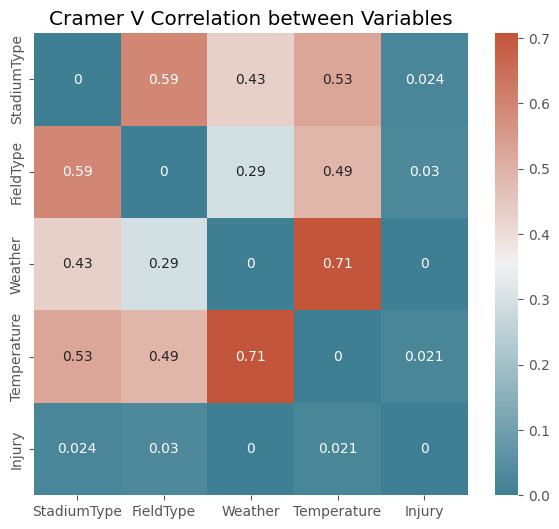

In [ ]:
cols = ["StadiumType", "FieldType", "Weather", "Temperature", "Injury"]
plot_cramers_v_heatmap(game_injury_df, cols)

In [ ]:
# joined cleaned games dataset and injury dataset
play_injury_df = injury_df.dropna(
                                subset = ['PlayKey']).set_index('PlayKey')\
                                         .join(play_df_cleaned.set_index('PlayKey'),
                                how = 'outer',
                                lsuffix='_left', rsuffix='_right'
                )

# fill null values for the injury columns with zeros
play_injury_df['DM_M1']  = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7']  = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# introduce a column with a flag indicating an injury
play_injury_df.DM_M1  = play_injury_df.DM_M1    - play_injury_df.DM_M7
play_injury_df.DM_M7  = play_injury_df.DM_M7    - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28   - play_injury_df.DM_M42

play_injury_df['Injury'] = play_injury_df['DM_M1'] \
                           + play_injury_df['DM_M7'] \
                           + play_injury_df['DM_M28']\
                           + play_injury_df['DM_M42']

# drop duplicated surface column
play_injury_df = play_injury_df.drop( columns=['Surface'] )

# create dummy variables
play_injury_df_dummies = pd.get_dummies(
                                play_injury_df,
                                columns = ['PlayType', 'PositionGroup'],
                                dummy_na = True, drop_first = True
                         )

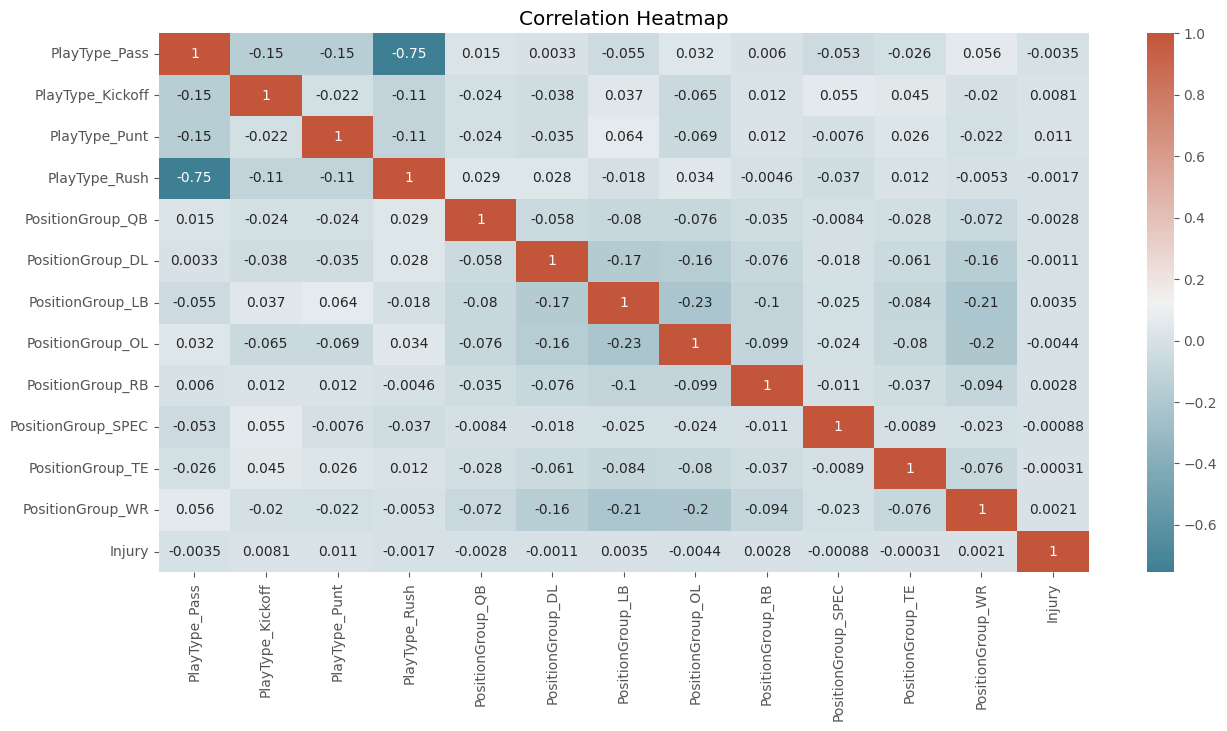

In [ ]:
corr_df = play_injury_df_dummies[
            ['PlayType_Pass', 'PlayType_Kickoff',
             'PlayType_Punt', 'PlayType_Rush',
             'PositionGroup_QB', 'PositionGroup_DL',
             'PositionGroup_LB', 'PositionGroup_OL',
             'PositionGroup_RB', 'PositionGroup_SPEC',
             'PositionGroup_TE', 'PositionGroup_WR','Injury']
         ].corr()

fig = plt.figure( figsize=(15,7) )
sns.heatmap(
    corr_df, annot=True,
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
)
plt.title('Correlation Heatmap')
plt.show()

TEXT

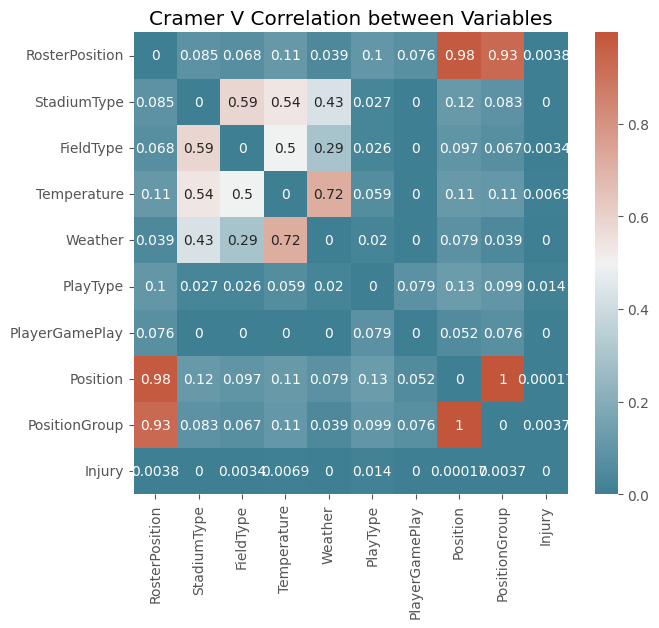

In [ ]:
cols = [
    "RosterPosition", "StadiumType",
    "FieldType", "Temperature", "Weather",
    'PlayType', 'PlayerGamePlay', 'Position',
    'PositionGroup', 'Injury'
]

plot_cramers_v_heatmap( play_injury_df, cols )

In [ ]:
plot_theils_u_heatmap(play_injury_df, cols )

NameError: ignored

In [ ]:
play_injury_df = injury_df.dropna(subset=['PlayKey']).set_index('PlayKey').join(
    play_df.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='_right'
)

# fill null values for the injury columns with zeros
play_injury_df['DM_M1'] = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7'] = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# introduce a column with a flag indicating an injury
play_injury_df.DM_M1 = play_injury_df.DM_M1 - play_injury_df.DM_M7
play_injury_df.DM_M7 = play_injury_df.DM_M7 - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28 - play_injury_df.DM_M42
play_injury_df['Injury'] = play_injury_df['DM_M1'] + play_injury_df['DM_M7'] + play_injury_df['DM_M28']+ play_injury_df['DM_M42']

# drop duplicated surface column
play_injury_df = play_injury_df.drop(columns=['Surface'])

# reset index
features_df = play_injury_df.copy().reset_index()
# drop the irrelevant columns
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
# convert into dummies
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)

y = features_df['Injury']
X = features_df.drop(columns=['Injury'])

In [ ]:
# LOGISTIC REGRESSION

# k-fold cross validation
skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]

    # resample dataset (to fix data label imbalance)
    resampler = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

    # logistic regression
    lr = LogisticRegression(max_iter=10000, multi_class='ovr', n_jobs=50)
    lr.fit(X_resampled, y_resampled)
    y_pred = lr.predict(X_test)

    print("----------------")
    print(f"Fold {i}:")
    print("predictions:", "0:",(y_pred==0).sum(), "1:",(y_pred==1).sum())
    print("actual vals:", "0:",(y_test==0).sum(), "1:",(y_test==1).sum())
    print("accuracy:", accuracy_score(y_test, y_pred))
    print("precision:", precision_score(y_test, y_pred))
    print("recall:", recall_score(y_test, y_pred))
    print("f1 score:", f1_score(y_test, y_pred))
    print("roc auc:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))


In [ ]:
# XG BOOST

# k-fold cross validation
skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]

    # resample dataset (to fix data label imbalance)
    resampler = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

    # xg boost
    model = xgb.XGBClassifier(max_depth=3,
                              learning_rate=0.1,
                              n_estimators=100,
                              n_jobs=50,
                              random_state=1)
    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test)

    print("----------")
    print("predictions:", "0:",(y_pred==0).sum(), "1:",(y_pred==1).sum())
    print("actual vals:", "0:",(y_test==0).sum(), "1:",(y_test==1).sum())
    print("precision:", precision_score(y_test, y_pred))
    print("recall:", recall_score(y_test, y_pred))
    print("accuracy:", accuracy_score(y_test, y_pred))
    print("confusion matrix:\n", confusion_matrix(y_test, y_pred))
    # model is pretty bad :(

In [ ]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(
        0,
        phi2 - ((k-1)*(r-1))/(n-1)
    )
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min(\
                                  (kcorr-1), (rcorr-1)
                                 )
                  )


In [ ]:
# Source:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def plot_cramers_v_heatmap(df, cols):
    corrM = np.zeros( ( len(cols),len(cols) ) )

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(
            pd.crosstab(df[col1], df[col2])
            .as_matrix()
        )
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(
        corr, annot=True,
        cmap = sns.diverging_palette(220, 20, as_cmap=True),
        ax = ax
    )
    ax.set_title("Cramer V Correlation between Variables")


In [ ]:
cols = ["StadiumType", "FieldType", "Weather", "Temperature", "Injury"]
plot_cramers_v_heatmap(game_injury_df, cols)